In [ ]:
# Install necessary libraries
!pip install pyspark wordcloud matplotlib


In [ ]:
# Import required libraries import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import files
import re
from sklearn.preprocessing import MinMaxScaler # For normalizing scores

#PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, explode, expr
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator

#Start Spark session
spark = SparkSession.builder.appName("TF-IDF Clustering").getOrCreate()

In [ ]:
# *Upload CSV File*
uploaded = files.upload() # User uploads file
file_name = list(uploaded.keys())[0]
df_pandas = pd.read_csv(file_name, encoding="ISO-8859-1") # Handle encoding issue
df_pandas.columns = ["text"] # Ensure column name consistency

# Convert Pandas DataFrame to Spark DataFrame
df = spark.createDataFrame(df_pandas)

Saving UAQTEresponses.csv to UAQTEresponses.csv


In [ ]:
# **Text Cleaning**
clean_text = (
  lower(col("text"))
  .alias("clean_text")
)

clean_text = regexp_replace(clean_text, r"http\S+", "") # Remove URLS
clean_text = regexp_replace(clean_text, r"@\w+", "") # Remove @mentions
clean_text = regexp_replace(clean_text, r"#\w+", "") # Remove hashtags
clean_text = regexp_replace(clean_text, r"[^\w\s]", "") # Remove special characters
df = df.withColumn("clean_text", clean_text)

In [ ]:
# **Tokenization & Stopword Removal**
tokenizer = Tokenizer (inputCol="clean_text", outputCol="words")

# Define additional stopwords
custom_stopwords = ["TES", "us" , "UAQTE", "uaqte", "u", "am", "i", "in", "im", "should", "like", "one", "also", "get", "use", "see", "going"]
default_stopwords = StopWordsRemover().getStopWords()
all_stopwords = list(set(default_stopwords + custom_stopwords))

stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=all_stopwords)

# ** Fix: Prevent nested arrays**
df = tokenizer.transform(df)
df = stopwords_remover.transform(df)
df = df.withColumn("filtered_words", expr("filter(flatten(array(filtered_words)), x -> x is not null)"))

In [ ]:
#Word Frequency Analysis [to check the words]
df_exploded = df.select(explode(col("filtered_words")).alias("word"))
df_exploded = df_exploded.filter(~col("word").isin(all_stopwords))
word_counts = df_exploded.groupBy("word").count().orderBy(col ("count").desc())

## Display Top 30 Words
word_counts.show(30)

+-------------+-----+
|         word|count|
+-------------+-----+
|    education|   34|
|      tuition|   34|
|         free|   27|
|    financial|   26|
|         help|   26|
|      college|   21|
|       helped|   21|
|       family|   19|
|beneficiaries|   19|
|         able|   19|
|        study|   18|
|         much|   16|
|     expenses|   15|
|      parents|   15|
|          lot|   14|
|       school|   14|
|        helps|   14|
|      studies|   14|
|      program|   11|
|       burden|   11|
|      without|   11|
|      student|   11|
|      helpful|   11|
|     students|   11|
|       pursue|   11|
|   university|   10|
|          fee|    9|
|       course|    9|
|  financially|    9|
|     studying|    9|
+-------------+-----+
only showing top 30 rows



In [ ]:
#**Convert Words to TF-IDF Features**
cv = CountVectorizer(inputCol="filtered_words", outputCol="raw_features", vocabSize=5000, minDF=2)
idf = IDF(inputCol="raw_features", outputCol="features")

In [ ]:
# ** Find the Optimal Number of Clusters** costs = []
costs=[]
silhouette_scores = []
k_values = range(2, 9) # Try K from 2 to 9

for k in k_values:
  kmeans = KMeans(featuresCol="features", k=k, seed=42, maxIter=100)
  pipeline = Pipeline(stages=[cv, idf, kmeans])
  model = pipeline.fit(df)
  result = model.transform(df)

  # Compute Within-Cluster Sum of Squares (WCSS)
  costs.append(model.stages[2].summary.trainingCost)

  # Compute Silhouette Score
  evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction")
  silhouette_scores.append(evaluator.evaluate(result))

In [ ]:
# **Normalize Scores for Comparison**
scaler = MinMaxScaler()
normalized_costs = scaler.fit_transform(np.array(costs).reshape(-1, 1)). flatten()
normalized_silhouette = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten()

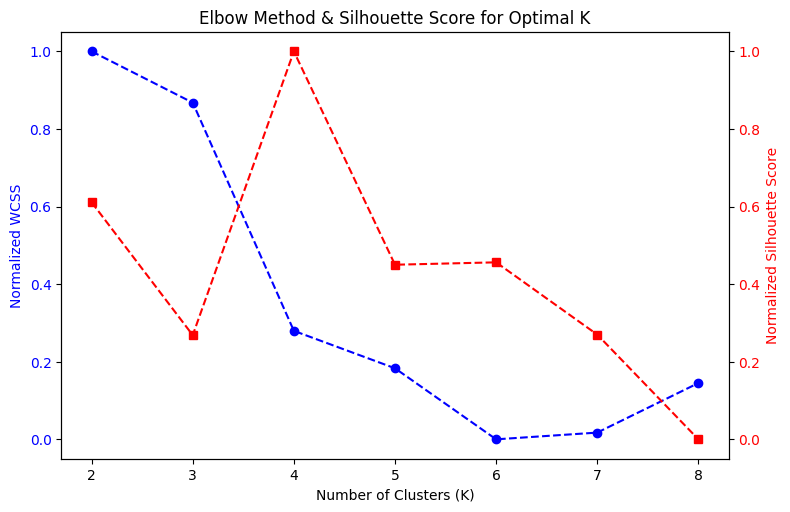

 Optimal number of clusters: 4


In [ ]:
# **Plot WCSS & Silhouette Score**
fig, ax1 = plt.subplots(figsize=(8, 5))  # Create a figure and one subplot

ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("Normalized WCSS", color="b")
ax1.plot(k_values, normalized_costs, marker="o", linestyle="--", color="b", label="WCSS(scaled)")
ax1.tick_params(axis="y", labelcolor="b")

# Create a secondary y-axis for Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel("Normalized Silhouette Score", color="r")
ax2.plot(k_values, normalized_silhouette, marker="s", linestyle="--", color="r", label="Silhouette Score (scaled)")
ax2.tick_params(axis="y", labelcolor="r")

fig.tight_layout()  # Adjust layout for better visualization
plt.title("Elbow Method & Silhouette Score for Optimal K")
plt.show()


best_k = k_values[np.argmax(silhouette_scores)]
print(f" Optimal number of clusters: {best_k}")

In [ ]:
# **Train Final K-Means Model with Best K**
kmeans = KMeans(featuresCol="features", k=best_k, seed=42, maxIter=100)
pipeline = Pipeline (stages=[cv, idf, kmeans])
model = pipeline.fit(df)
result = model.transform(df)

#**Compute Final Silhouette Score**
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction")
silhouette_score = evaluator.evaluate(result)
print(f"Final Silhouette Score: {silhouette_score:.4f}")

#**Display Cluster Assignments**
result.select("text", "prediction").show(truncate=False)


Final Silhouette Score: 0.5064
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                                                                                                                                                                                                                                                                                                                                     |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# **Extract Top Words Per Cluster**
vocab = model.stages[0].vocabulary # Extract vocabulary from CountVectorizer
cluster_centers = model.stages [2].clusterCenters()

# Extract cluster centers
print("\n**Top Words Per Cluster:**")
for i, center in enumerate(cluster_centers):
  top_indices = np.argsort(center)[::-1][:10] # Get top 10 words
  top_words = [vocab[idx] for idx in top_indices]
  print(f"Cluster {i}: {', '.join(top_words)}")


**Top Words Per Cluster:**
Cluster 0: education, tuition, financial, helped, free, able, help, college, family, beneficiaries
Cluster 1: huge, access, without, study, act, take, universal, want, help, private
Cluster 2: better, thank, helps, much, beneficiaries, longer, happy, others, god, say
Cluster 3: thank, school, got, chance, public, lost, unifast, person, ched, god


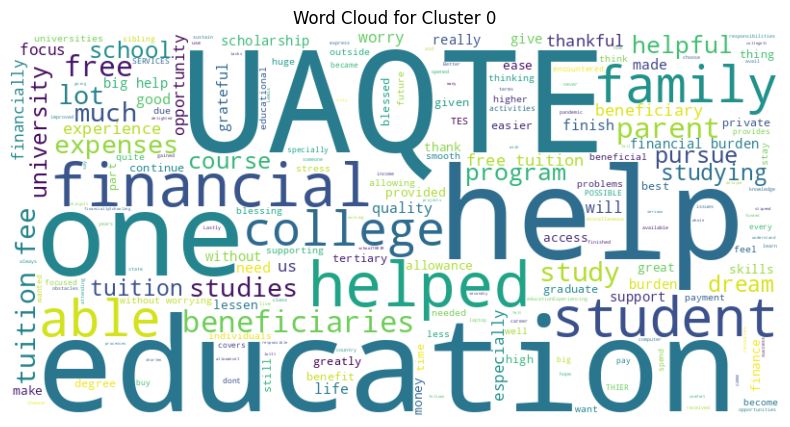

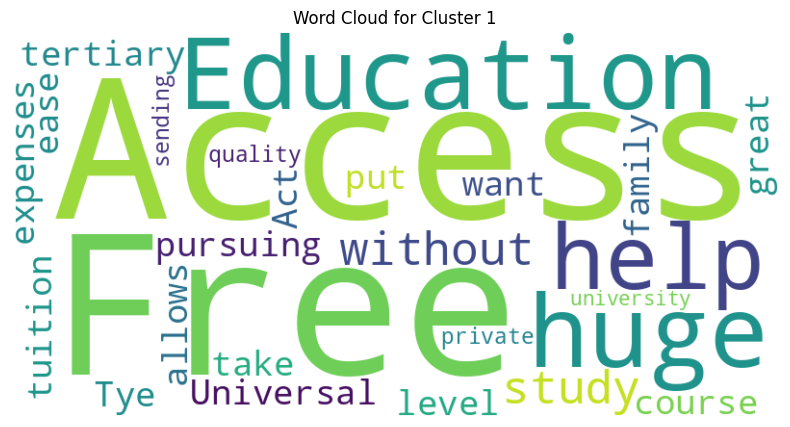

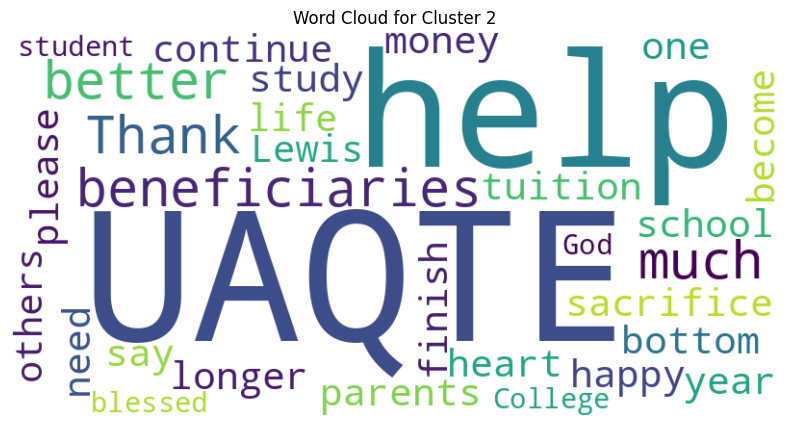

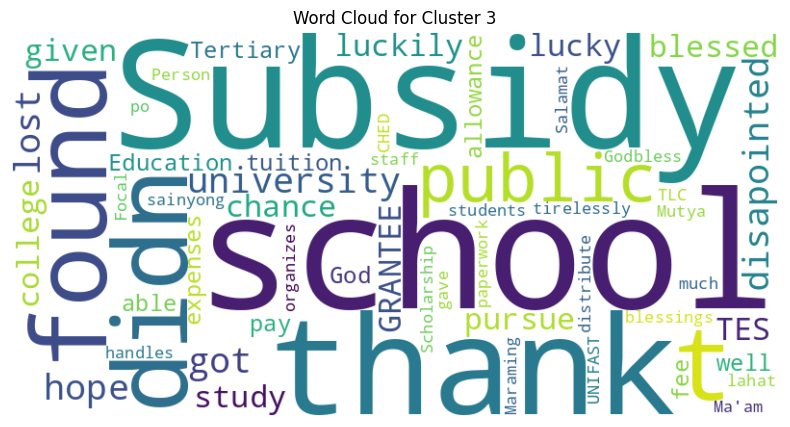

In [ ]:
#**Generate Word Clouds Per Cluster**
result_pandas = result.select("text", "prediction").toPandas()

for cluster_id in range(best_k):
  cluster_texts = result_pandas [result_pandas["prediction"] == cluster_id]["text"].str.cat(sep="")
  wordcloud = WordCloud (width=800, height=400, background_color="white").generate(cluster_texts)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"Word Cloud for Cluster {cluster_id}")
  plt.show()